# Selal: Building A Content-Based Recommender System

## Setting up module imports and autoreload

In [1]:
import sys
sys.path.append('../src')

%load_ext autoreload
%autoreload 2

## Package imports

In [2]:
import os
import re

from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import csr_matrix, csc_matrix

from sklearn.metrics.pairwise import cosine_similarity

import scipy as sp

import pickle

tqdm.pandas()

## Constants and Configuration

In [3]:
ROOT_DIR = '/workspace'
DATA_DIR = 'data'
DATA_FILENAME = 'csv_for_case_study_V1.csv'

DATA_PATH = os.path.join(ROOT_DIR, DATA_DIR, DATA_FILENAME)

DATE_COLUMNS = ['Event_Date']

## Read data

In [4]:
data = pd.read_csv(DATA_PATH, parse_dates=DATE_COLUMNS)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   index         500000 non-null  int64              
 1   product_id    500000 non-null  int64              
 2   customer_id   500000 non-null  int64              
 3   product_name  500000 non-null  object             
 4   Event_Date    477821 non-null  datetime64[ns, UTC]
 5   Event         500000 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 22.9+ MB


In [5]:
data.head()

,index,product_id,customer_id,product_name,Event_Date,Event
0,2112112,1,2726055,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,2023-03-28 02:03:31+00:00,purchased
1,12110444,2,8307875,عطر 002,2023-02-07 23:23:49+00:00,cart
2,8908469,3,14308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,2023-03-16 20:37:03+00:00,cart
3,40921,4,13235575,ساعة يد رجالية M34-2,2023-02-22 17:27:47+00:00,cart
4,14635759,5,1652827,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,2023-02-28 19:05:40+00:00,cart


## Data Preprocessing

In [6]:
data_processed = data.copy()

### Missing values

In [7]:
data_processed.isna().sum()

index               0
product_id          0
customer_id         0
product_name        0
Event_Date      22179
Event               0
dtype: int64

In [8]:
global_median_timestamp = data_processed.Event_Date.median()

In [9]:
dict_product_median_event_dates = data_processed.groupby('product_id')['Event_Date'].agg('median').to_dict()

dict_product_median_event_dates

{1: Timestamp('2023-03-02 20:37:03.500000+0000', tz='UTC'),
 2: Timestamp('2023-03-15 14:08:53+0000', tz='UTC'),
 3: Timestamp('2023-03-16 20:37:03+0000', tz='UTC'),
 4: Timestamp('2023-02-22 17:27:47+0000', tz='UTC'),
 5: Timestamp('2023-01-15 22:46:32.500000+0000', tz='UTC'),
 6: Timestamp('2022-12-14 01:46:25+0000', tz='UTC'),
 7: Timestamp('2022-12-25 06:56:26+0000', tz='UTC'),
 8: Timestamp('2023-02-01 21:49:25+0000', tz='UTC'),
 9: Timestamp('2022-12-13 05:17:49+0000', tz='UTC'),
 10: Timestamp('2023-02-10 22:41:37+0000', tz='UTC'),
 11: Timestamp('2023-03-30 06:12:08+0000', tz='UTC'),
 12: Timestamp('2023-03-04 00:05:12+0000', tz='UTC'),
 13: Timestamp('2023-01-07 22:20:59.500000+0000', tz='UTC'),
 14: Timestamp('2023-01-13 22:29:09+0000', tz='UTC'),
 15: Timestamp('1850-05-12 01:10:30.072611840+0000', tz='UTC'),
 16: Timestamp('2023-02-15 02:34:35+0000', tz='UTC'),
 17: Timestamp('2023-01-25 15:28:27+0000', tz='UTC'),
 18: Timestamp('2023-01-30 11:11:53.500000+0000', tz='UTC'),

In [10]:
data_processed['Event_Date_Processed'] = data_processed.apply(lambda x: x['Event_Date'] if pd.notna(x['Event_Date']) else dict_product_median_event_dates[x['product_id']], axis=1)


data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   index                 500000 non-null  int64              
 1   product_id            500000 non-null  int64              
 2   customer_id           500000 non-null  int64              
 3   product_name          500000 non-null  object             
 4   Event_Date            477821 non-null  datetime64[ns, UTC]
 5   Event                 500000 non-null  object             
 6   Event_Date_Processed  486149 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(3), object(2)
memory usage: 26.7+ MB


In [11]:
data_processed['Event_Date_Processed'] = data_processed['Event_Date'].fillna(global_median_timestamp)

data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   index                 500000 non-null  int64              
 1   product_id            500000 non-null  int64              
 2   customer_id           500000 non-null  int64              
 3   product_name          500000 non-null  object             
 4   Event_Date            477821 non-null  datetime64[ns, UTC]
 5   Event                 500000 non-null  object             
 6   Event_Date_Processed  500000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(3), object(2)
memory usage: 26.7+ MB


### Inconsistencies

In [12]:
data.dtypes

index                         int64
product_id                    int64
customer_id                   int64
product_name                 object
Event_Date      datetime64[ns, UTC]
Event                        object
dtype: object

In [13]:
pd.to_datetime(data.Event_Date)

0        2023-03-28 02:03:31+00:00
1        2023-02-07 23:23:49+00:00
2        2023-03-16 20:37:03+00:00
3        2023-02-22 17:27:47+00:00
4        2023-02-28 19:05:40+00:00
                    ...           
499995   2023-01-01 14:55:56+00:00
499996   2023-03-22 12:45:38+00:00
499997   2023-03-28 00:45:20+00:00
499998   2023-01-06 19:39:36+00:00
499999                         NaT
Name: Event_Date, Length: 500000, dtype: datetime64[ns, UTC]

In [14]:
data_processed['Event_Date'].apply(lambda x: str(x)[-6:]).value_counts()

Event_Date
+00:00    477821
NaT        22179
Name: count, dtype: int64

In [15]:
data_processed.Event.value_counts()

Event
cart              305129
purchased         166423
wishlist           22179
search_keyword      3190
rating              3079
Name: count, dtype: int64

In [16]:
data_processed.groupby('product_id')['product_name'].nunique().value_counts()

product_name
1    200026
2       296
3         3
Name: count, dtype: int64

In [17]:
df_product_number_of_names = data_processed.groupby('product_id')['product_name'].nunique().reset_index().rename(columns={'product_name':'number_of_names'})
more_than_one_name_products = df_product_number_of_names.query('number_of_names > 1').product_id.unique()
more_than_one_name_products

array([   126,    188,    770,   1042,   1292,   1326,   1408,   1736,
         1773,   1784,   1927,   2291,   2348,   2416,   2440,   2609,
         2804,   3020,   3369,   3477,   3548,   3643,   3659,   3866,
         4020,   4252,   4496,   4689,   4732,   4859,   5046,   5379,
         5508,   6271,   6575,   6613,   7207,   7238,   7504,   7854,
         8340,   9009,   9243,   9419,   9444,   9675,   9845,   9876,
        10858,  10998,  11320,  11610,  11837,  12097,  12203,  12330,
        12491,  12557,  12615,  12987,  13043,  13283,  13547,  13689,
        13939,  14130,  14534,  14562,  14648,  14873,  15539,  15540,
        15668,  15792,  15827,  17467,  17520,  17921,  18048,  18367,
        18488,  18583,  18649,  18675,  18849,  18939,  19322,  19405,
        20116,  20556,  21122,  21260,  21475,  21507,  21888,  22130,
        23301,  24612,  24874,  25209,  25249,  25552,  25603,  25635,
        25997,  26223,  26284,  26516,  26984,  27352,  27735,  27865,
      

In [18]:
data_processed.query('product_id in @more_than_one_name_products')

,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed
125,10939736,126,8023941,ماكينة لكامل الجسم للرجال والنساء لون أسود,2023-03-08 02:00:54+00:00,purchased,2023-03-08 02:00:54+00:00
172,27005212,126,4407363,ماكينة لكامل الجسم للرجال والنساء لون أزرق غا...,2023-01-02 13:29:07+00:00,purchased,2023-01-02 13:29:07+00:00
188,12846797,188,6456908,5400 جوهره-حساب مشحون وجاهز,2023-02-03 03:13:26+00:00,purchased,2023-02-03 03:13:26+00:00
722,27033077,126,2435868,ماكينة لكامل الجسم للرجال والنساء لون أزرق غا...,2023-01-17 03:40:41+00:00,purchased,2023-01-17 03:40:41+00:00
796,2487892,770,50718,صينية تقديم,2023-02-22 20:05:37+00:00,cart,2023-02-22 20:05:37+00:00
...,...,...,...,...,...,...,...
499807,12435624,19405,11403162,عرق السوس من دروب,2023-02-27 15:13:41+00:00,purchased,2023-02-27 15:13:41+00:00
499841,35342407,3659,8763790,كرتون ماء 20 علبه بدون عباره شامل التوصيل للمس...,2023-01-10 07:18:45+00:00,cart,2023-01-10 07:18:45+00:00
499888,18206497,4732,9250093,"يلا لودو - 13,580 ماسة",2023-01-02 01:22:51+00:00,cart,2023-01-02 01:22:51+00:00
499919,6504520,126,6759677,ماكينة لكامل الجسم للرجال والنساء لون أزرق غا...,2022-12-28 12:38:27+00:00,purchased,2022-12-28 12:38:27+00:00


In [19]:
random_product_with_more_than_one_name = df_product_number_of_names.query('number_of_names > 1').product_id.sample(1).tolist()[0]
pprint(data_processed.query('product_id == @random_product_with_more_than_one_name')['product_name'].tolist())

['كارمكس مرطب شفاه بالكرز 10جرام', 'كارمكس مرطب شفاه طبي بالكرز المنعش 10 جرام']


In [20]:
random_product_with_more_than_one_name = df_product_number_of_names.query('number_of_names > 1').product_id.sample(1).tolist()[0]
pprint(data_processed.query('product_id == @random_product_with_more_than_one_name')['product_name'].tolist())

['بيردون مس دير 28',
 'بيردون مس دير 28',
 'بيردون 28',
 'بيردون 28',
 'بيردون مس دير 28',
 'بيردون مس دير 28']


In [21]:
for group in data_processed.groupby('product_id')['product_name']:
    dict_product_name_number_of_purchases = group[1].value_counts().to_dict()
    if len(dict_product_name_number_of_purchases.keys()) > 1:
        pprint(dict_product_name_number_of_purchases)

{'ماكينة  لكامل الجسم للرجال والنساء لون أزرق غامق مميز': 971,
 'ماكينة  لكامل الجسم للرجال والنساء لون أسود': 1311}
{'5400 جوهره-حساب مشحون وجاهز': 4, '6300 جوهره-حساب مشحون وجاهز': 1}
{'صينية تقديم': 1, 'صينية تقديم خشب': 1}
{'Gris': 12, 'Gris  100ML': 6}
{'أصابع البقلاوة بالكاجو': 11, 'أصابع البقلاوة بالكاجو كبير': 1}
{'الثلاثاء 13رمضان - كرتون واحد 20 علبه': 4,
 'بدون عباره-الاثنين 19 رمضان - كرتون واحد 20 علبه': 2}
{'عرض 10 كيابل  شاحن روك من اختيارك ذو كفاءة عالية 1 متر': 1,
 'عرض 10 كيابل شاحن - متوافقة مع جميع الأجهزة ذو كفاءة عالية 1 متر من اختيارك - ماركة فيدا': 3}
{'25200 شده': 1, 'نشحن لك 25200 شدة': 1}
{'بكج الشموخ': 12, 'بكج الشموخ عبايتين': 7}
{'بيردون 02': 2, 'بيردون ديلينا 02': 4}
{'الهيبة 50 مل(يوصلك حد اقصئ تاريخ 12/04/2023)': 145,
 'الهيبة 50 مل(يوصلك حد اقصئ تاريخ 17/04/2023)': 50}
{'بكج رمضاني جديد': 1, 'عرض رمضاني': 43}
{'درزن ارواج بديل سيفورا  بشكل مطور': 5,
 'درزن ارواج بديل سيفورا لافمي  بشكل مطور': 6}
{'زيت لانبات الشعر تركيز 10% +مادة الامنكسيل تسرع النمو ا

In [22]:
data_processed['product_name_Processed'] = data_processed['product_name'].copy()

for group in tqdm(data_processed.groupby('product_id')[['product_name', 'Event_Date']]):
    product_id = group[0]
    dict_product_name_event_dates = group[1].set_index('product_name')['Event_Date'].to_dict()
    
    if len(dict_product_name_event_dates.keys()) > 1:
        # pprint(dict_product_name_event_dates)
        to_replace_names = list(dict_product_name_event_dates.keys())
        new_value = max(dict_product_name_event_dates, key=dict_product_name_event_dates.get)
        product_id_mask = (data_processed.product_id == product_id)
        to_replace_names_mask = (data_processed.product_name.isin(to_replace_names))
        data_processed.loc[product_id_mask & to_replace_names_mask, ['product_name_Processed']] = new_value

data_processed

100%|█████████████████████████████████| 200325/200325 [00:28<00:00, 6944.58it/s]


,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed
0,2112112,1,2726055,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,2023-03-28 02:03:31+00:00,purchased,2023-03-28 02:03:31+00:00,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر
1,12110444,2,8307875,عطر 002,2023-02-07 23:23:49+00:00,cart,2023-02-07 23:23:49+00:00,عطر 002
2,8908469,3,14308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,2023-03-16 20:37:03+00:00,cart,2023-03-16 20:37:03+00:00,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...
3,40921,4,13235575,ساعة يد رجالية M34-2,2023-02-22 17:27:47+00:00,cart,2023-02-22 17:27:47+00:00,ساعة يد رجالية M34-2
4,14635759,5,1652827,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,2023-02-28 19:05:40+00:00,cart,2023-02-28 19:05:40+00:00,فوط تنظيف ميكروفايبر ريكسو - 6 حبات
...,...,...,...,...,...,...,...,...
499995,4328960,200324,1947203,ديجاست كحلي فصوص,2023-01-01 14:55:56+00:00,cart,2023-01-01 14:55:56+00:00,ديجاست كحلي فصوص
499996,5175565,71377,4749249,خلطة عسالون المميزة,2023-03-22 12:45:38+00:00,cart,2023-03-22 12:45:38+00:00,خلطة عسالون المميزة
499997,14771583,92590,478225,طقم مسك لبني,2023-03-28 00:45:20+00:00,cart,2023-03-28 00:45:20+00:00,طقم مسك لبني
499998,13474125,410,3332058,جهاز الالعاب,2023-01-06 19:39:36+00:00,cart,2023-01-06 19:39:36+00:00,جهاز الالعاب


In [23]:
data_processed.groupby('product_id')['product_name_Processed'].nunique().value_counts()

product_name_Processed
1    200325
Name: count, dtype: int64

### Duplicates

In [24]:
data_processed['unique_id'] = data_processed.apply(lambda x: str(x['index']) + str(x['product_id']) + str(x['customer_id']), axis=1)
data_processed

,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed,unique_id
0,2112112,1,2726055,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,2023-03-28 02:03:31+00:00,purchased,2023-03-28 02:03:31+00:00,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,211211212726055
1,12110444,2,8307875,عطر 002,2023-02-07 23:23:49+00:00,cart,2023-02-07 23:23:49+00:00,عطر 002,1211044428307875
2,8908469,3,14308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,2023-03-16 20:37:03+00:00,cart,2023-03-16 20:37:03+00:00,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,8908469314308668
3,40921,4,13235575,ساعة يد رجالية M34-2,2023-02-22 17:27:47+00:00,cart,2023-02-22 17:27:47+00:00,ساعة يد رجالية M34-2,40921413235575
4,14635759,5,1652827,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,2023-02-28 19:05:40+00:00,cart,2023-02-28 19:05:40+00:00,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,1463575951652827
...,...,...,...,...,...,...,...,...,...
499995,4328960,200324,1947203,ديجاست كحلي فصوص,2023-01-01 14:55:56+00:00,cart,2023-01-01 14:55:56+00:00,ديجاست كحلي فصوص,43289602003241947203
499996,5175565,71377,4749249,خلطة عسالون المميزة,2023-03-22 12:45:38+00:00,cart,2023-03-22 12:45:38+00:00,خلطة عسالون المميزة,5175565713774749249
499997,14771583,92590,478225,طقم مسك لبني,2023-03-28 00:45:20+00:00,cart,2023-03-28 00:45:20+00:00,طقم مسك لبني,1477158392590478225
499998,13474125,410,3332058,جهاز الالعاب,2023-01-06 19:39:36+00:00,cart,2023-01-06 19:39:36+00:00,جهاز الالعاب,134741254103332058


In [25]:
assert data_processed['unique_id'].nunique() == len(data_processed)

In [26]:
data_processed[data_processed.duplicated(subset='index', keep=False)].sort_values(by='index')

,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed,unique_id
400999,40,8860,494,عباية قطعتين منفصلة بجيوب,NaT,wishlist,2023-02-10 16:25:02+00:00,عباية قطعتين منفصلة بجيوب,408860494
291263,40,32054,8288656,GOLD COLLECTION,2022-12-20 20:40:40+00:00,rating,2022-12-20 20:40:40+00:00,GOLD COLLECTION,40320548288656
365891,52,14005,970097,شاهد VIP الباقة الرياضية - سنة,2023-02-02 00:41:38+00:00,purchased,2023-02-02 00:41:38+00:00,شاهد VIP الباقة الرياضية - سنة,5214005970097
72946,52,46600,426331,سكر ابيض الخير 100 ظرف × 5غ,2023-03-01 12:58:56+00:00,rating,2023-03-01 12:58:56+00:00,سكر ابيض الخير 100 ظرف × 5غ,5246600426331
126394,837,4201,334377,بكج محاصيل محمصة وتر | WTR PKG COFFEE,2022-12-21 05:40:02+00:00,rating,2022-12-21 05:40:02+00:00,بكج محاصيل محمصة وتر | WTR PKG COFFEE,8374201334377
...,...,...,...,...,...,...,...,...,...
402520,36623855,82852,1365729,ID Holder,2023-01-16 03:24:50+00:00,purchased,2023-01-16 03:24:50+00:00,ID Holder,36623855828521365729
15254,36917591,12165,3665549,اشتراك يوتيوب بريميوم شهر,2022-12-20 13:40:23+00:00,purchased,2022-12-20 13:40:23+00:00,اشتراك يوتيوب بريميوم شهر,36917591121653665549
395788,36917591,170081,1681943,AF88,2023-01-23 14:29:31+00:00,cart,2023-01-23 14:29:31+00:00,AF88,369175911700811681943
484909,37188642,78569,2262143,كرتون خلاص القصيم ملكي (مجروش),2022-12-09 21:35:40+00:00,purchased,2022-12-09 21:35:40+00:00,كرتون خلاص القصيم ملكي (مجروش),37188642785692262143


In [27]:
data_processed[data_processed.duplicated(subset=['product_id', 'customer_id'], keep=False)].sort_values(by=['customer_id'])

,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed,unique_id
205591,4091348,105091,2340,فستان Red chiffon,2023-02-18 19:39:33+00:00,cart,2023-02-18 19:39:33+00:00,فستان Red chiffon,40913481050912340
239913,4092102,105091,2340,فستان Red chiffon,2023-02-19 15:07:50+00:00,cart,2023-02-19 15:07:50+00:00,فستان Red chiffon,40921021050912340
133690,1194487,75641,5265,كرستين لونق لاستينق مناكير طلاء اظافر - 121,2023-03-26 04:31:15+00:00,cart,2023-03-26 04:31:15+00:00,كرستين لونق لاستينق مناكير طلاء اظافر - 121,1194487756415265
363016,1194485,75641,5265,كرستين لونق لاستينق مناكير طلاء اظافر - 121,2023-03-26 04:31:15+00:00,cart,2023-03-26 04:31:15+00:00,كرستين لونق لاستينق مناكير طلاء اظافر - 121,1194485756415265
360718,1455785,159203,5457,طقم مساعدات كبوت باترول 2005-2022 ياباني,2023-03-06 14:08:02+00:00,cart,2023-03-06 14:08:02+00:00,طقم مساعدات كبوت باترول 2005-2022 ياباني,14557851592035457
...,...,...,...,...,...,...,...,...,...
316748,6224567,13011,14610498,ايتونز 300 ريال سعودي,2023-03-29 12:36:32+00:00,cart,2023-03-29 12:36:32+00:00,ايتونز 300 ريال سعودي,62245671301114610498
416208,99300,175668,14619660,كونسيلر شيب تيب ميديوم تان ساند 36S من تارت,2023-03-31 21:40:35+00:00,cart,2023-03-31 21:40:35+00:00,كونسيلر شيب تيب ميديوم تان ساند 36S من تارت,9930017566814619660
414459,99242,175668,14619660,كونسيلر شيب تيب ميديوم تان ساند 36S من تارت,2023-03-31 21:38:56+00:00,cart,2023-03-31 21:38:56+00:00,كونسيلر شيب تيب ميديوم تان ساند 36S من تارت,9924217566814619660
266012,1077973,9647,14637824,سامسونج جالكسي A04e ذاكرة 32 جيجا بايت تقنية ا...,2023-03-31 17:42:45+00:00,cart,2023-03-31 17:42:45+00:00,سامسونج جالكسي A04e ذاكرة 32 جيجا بايت تقنية ا...,1077973964714637824


In [28]:
df_duplicated_customer_product_event_list = data_processed.groupby(['customer_id', 'product_id'])[['Event', 'Event_Date']].agg(list).reset_index().rename(columns={'Event':'Event_List', 'Event_Date':'Event_Date_List'})
df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(len) > 1]['Event_List'].value_counts()

Event_List
[cart, cart]                                                                                                                                                                                                                                                                                                                  2276
[purchased, purchased]                                                                                                                                                                                                                                                                                                         626
[cart, purchased]                                                                                                                                                                                                                                                                                                              452
[purchased, cart]   

In [29]:
df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(str) == "['cart', 'cart']"]

,customer_id,product_id,Event_List,Event_Date_List
161,2340,105091,"[cart, cart]","[2023-02-18 19:39:33+00:00, 2023-02-19 15:07:5..."
385,5265,75641,"[cart, cart]","[2023-03-26 04:31:15+00:00, 2023-03-26 04:31:1..."
405,5457,159203,"[cart, cart]","[2023-03-06 14:08:02+00:00, 2023-03-06 14:08:0..."
426,5701,13581,"[cart, cart]","[2023-02-04 02:01:45+00:00, 2023-02-04 02:09:5..."
622,8282,55912,"[cart, cart]","[2023-02-02 18:36:11+00:00, 2023-02-02 18:36:1..."
...,...,...,...,...
494528,14596613,7576,"[cart, cart]","[2023-03-28 19:54:42+00:00, 2023-03-28 13:26:0..."
494586,14599245,466,"[cart, cart]","[2023-03-28 18:25:31+00:00, 2023-03-28 18:28:4..."
494862,14610498,13011,"[cart, cart]","[2023-03-29 12:35:15+00:00, 2023-03-29 12:36:3..."
495046,14619660,175668,"[cart, cart]","[2023-03-31 21:38:56+00:00, 2023-03-31 21:40:3..."


In [30]:
df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(str) == "['purchased', 'purchased']"]

,customer_id,product_id,Event_List,Event_Date_List
1270,16218,2715,"[purchased, purchased]","[2023-02-18 14:01:55+00:00, 2023-02-18 14:01:5..."
1272,16270,6049,"[purchased, purchased]","[2023-03-26 17:18:08+00:00, 2023-02-03 17:24:1..."
2452,30225,15713,"[purchased, purchased]","[2023-02-03 23:42:30+00:00, 2023-02-03 23:42:3..."
3168,38850,29025,"[purchased, purchased]","[2023-02-01 16:42:13+00:00, 2023-02-01 16:42:1..."
3592,43588,29578,"[purchased, purchased]","[2023-01-10 12:55:02+00:00, 2022-12-28 09:20:4..."
...,...,...,...,...
491025,14442607,42348,"[purchased, purchased]","[2023-03-11 21:52:55+00:00, 2023-03-11 21:52:5..."
491900,14480422,48900,"[purchased, purchased]","[2023-03-31 09:06:55+00:00, 2023-03-27 15:13:0..."
492036,14486004,104525,"[purchased, purchased]","[2023-03-16 17:27:05+00:00, 2023-03-16 23:06:2..."
493027,14528244,127596,"[purchased, purchased]","[2023-02-16 21:58:06+00:00, 2023-02-16 21:58:0..."


In [31]:
df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(str) == "['purchased', 'purchased']"].Event_Date_List.apply(lambda x: abs(x[0] - x[1]))

1270      0 days 00:00:00
1272     50 days 23:53:50
2452      0 days 00:00:00
3168      0 days 00:00:00
3592     13 days 03:34:18
               ...       
491025    0 days 00:00:00
491900    3 days 17:53:55
492036    0 days 05:39:18
493027    0 days 00:00:00
494390    0 days 00:00:00
Name: Event_Date_List, Length: 626, dtype: timedelta64[ns]

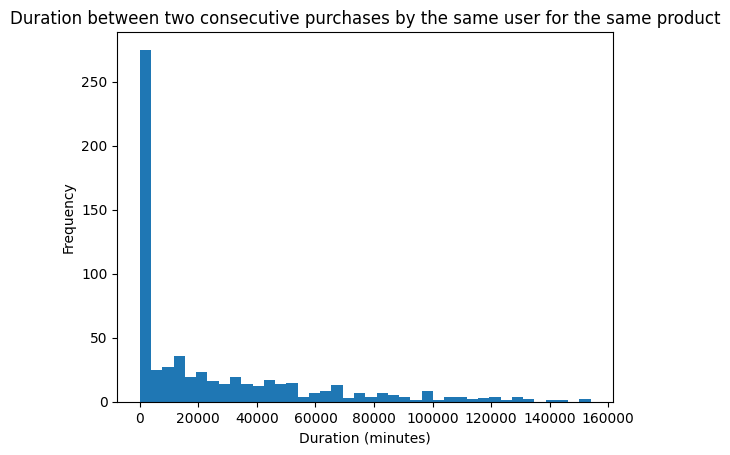

In [32]:
(df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(str) == "['purchased', 'purchased']"].Event_Date_List.apply(lambda x: abs(x[0] - x[1])).dt.total_seconds()/(60)).plot.hist(bins=40)
plt.title('Duration between two consecutive purchases by the same user for the same product')
plt.xlabel('Duration (minutes)')
plt.show()

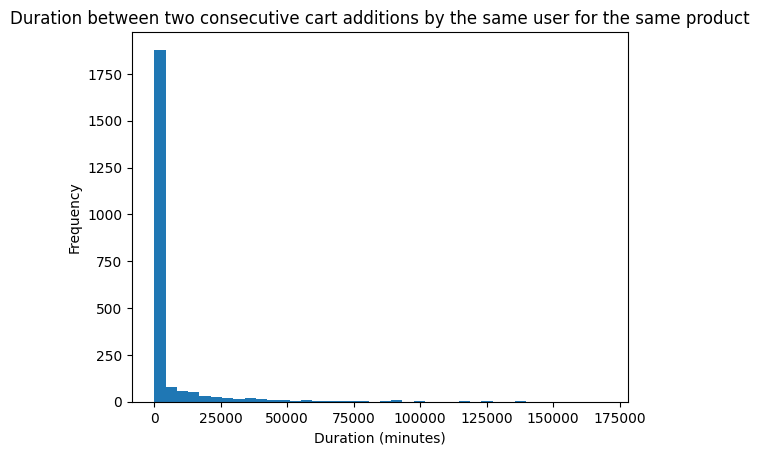

In [33]:
(df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(str) == "['cart', 'cart']"].Event_Date_List.apply(lambda x: abs(x[0] - x[1])).dt.total_seconds()/(60)).plot.hist(bins=40)
plt.title('Duration between two consecutive cart additions by the same user for the same product')
plt.xlabel('Duration (minutes)')
plt.show()

In [34]:
duplicated_purchased_event_list = ['purchased', 'purchased']
duration_between_events_minutes_purchased_threshold = 20

duplicated_cart_event_list = ['cart', 'cart']
duration_between_events_minutes_cart_threshold = 120


duplicated_unique_ids = []
for group in tqdm(data_processed.groupby(['customer_id', 'product_id'])[['unique_id', 'Event', 'Event_Date']]):
    keys, df = group
    customer_id, product_id = keys
    if len(df) < 2:
        continue
    event_list = df['Event'].tolist()
    if event_list == duplicated_cart_event_list:
        timestamps = df['Event_Date'].tolist()
        duration_between_events_minutes = abs(timestamps[0] - timestamps[1]).total_seconds() / (60)
        if duration_between_events_minutes < duration_between_events_minutes_cart_threshold:
            dict_product_id_event_dates = df.set_index('unique_id')['Event_Date'].to_dict()
            duplicated_unique_id = min(dict_product_id_event_dates, key=dict_product_id_event_dates.get)
            duplicated_unique_ids.append(duplicated_unique_id)
            
    if event_list == duplicated_purchased_event_list:
        timestamps = df['Event_Date'].tolist()
        duration_between_events_minutes = abs(timestamps[0] - timestamps[1]).total_seconds() / (60)
        if duration_between_events_minutes < duration_between_events_minutes_purchased_threshold:
            dict_product_id_event_dates = df.set_index('unique_id')['Event_Date'].to_dict()
            duplicated_unique_id = min(dict_product_id_event_dates, key=dict_product_id_event_dates.get)
            duplicated_unique_ids.append(duplicated_unique_id)

print(f'{len(duplicated_unique_ids)} duplicated records found')

100%|████████████████████████████████| 495598/495598 [00:07<00:00, 64241.25it/s]

1682 duplicated records found


In [35]:
data_processed = data_processed[~data_processed.unique_id.isin(duplicated_unique_ids)]
data_processed

,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed,unique_id
0,2112112,1,2726055,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,2023-03-28 02:03:31+00:00,purchased,2023-03-28 02:03:31+00:00,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,211211212726055
1,12110444,2,8307875,عطر 002,2023-02-07 23:23:49+00:00,cart,2023-02-07 23:23:49+00:00,عطر 002,1211044428307875
2,8908469,3,14308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,2023-03-16 20:37:03+00:00,cart,2023-03-16 20:37:03+00:00,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,8908469314308668
3,40921,4,13235575,ساعة يد رجالية M34-2,2023-02-22 17:27:47+00:00,cart,2023-02-22 17:27:47+00:00,ساعة يد رجالية M34-2,40921413235575
4,14635759,5,1652827,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,2023-02-28 19:05:40+00:00,cart,2023-02-28 19:05:40+00:00,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,1463575951652827
...,...,...,...,...,...,...,...,...,...
499995,4328960,200324,1947203,ديجاست كحلي فصوص,2023-01-01 14:55:56+00:00,cart,2023-01-01 14:55:56+00:00,ديجاست كحلي فصوص,43289602003241947203
499996,5175565,71377,4749249,خلطة عسالون المميزة,2023-03-22 12:45:38+00:00,cart,2023-03-22 12:45:38+00:00,خلطة عسالون المميزة,5175565713774749249
499997,14771583,92590,478225,طقم مسك لبني,2023-03-28 00:45:20+00:00,cart,2023-03-28 00:45:20+00:00,طقم مسك لبني,1477158392590478225
499998,13474125,410,3332058,جهاز الالعاب,2023-01-06 19:39:36+00:00,cart,2023-01-06 19:39:36+00:00,جهاز الالعاب,134741254103332058


In [36]:
df_duplicated_customer_product_event_list = data_processed.groupby(['customer_id', 'product_id'])[['Event', 'Event_Date']].agg(list).reset_index().rename(columns={'Event':'Event_List', 'Event_Date':'Event_Date_List'})

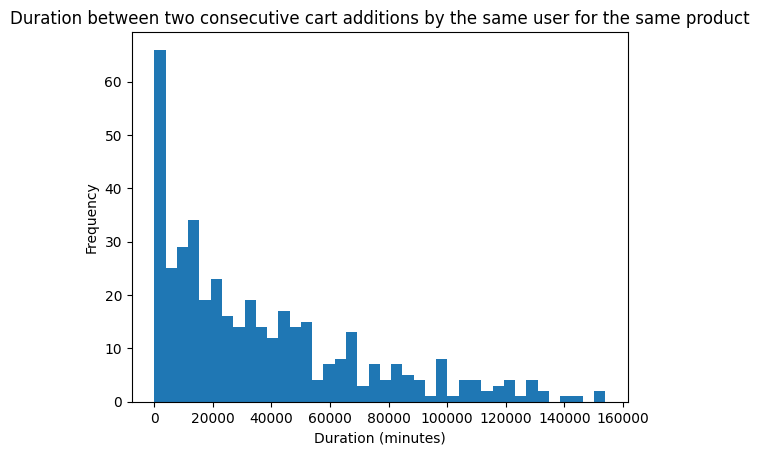

In [37]:
(df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(str) == "['purchased', 'purchased']"].Event_Date_List.apply(lambda x: abs(x[0] - x[1])).dt.total_seconds()/(60)).plot.hist(bins=40)
plt.title('Duration between two consecutive cart additions by the same user for the same product')
plt.xlabel('Duration (minutes)')
plt.show()

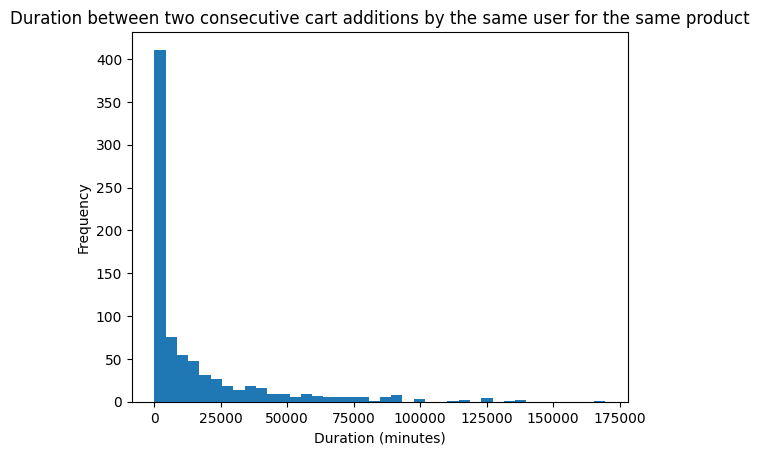

In [38]:
(df_duplicated_customer_product_event_list[df_duplicated_customer_product_event_list.Event_List.apply(str) == "['cart', 'cart']"].Event_Date_List.apply(lambda x: abs(x[0] - x[1])).dt.total_seconds()/(60)).plot.hist(bins=40)
plt.title('Duration between two consecutive cart additions by the same user for the same product')
plt.xlabel('Duration (minutes)')
plt.show()

In [39]:
data_processed

,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed,unique_id
0,2112112,1,2726055,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,2023-03-28 02:03:31+00:00,purchased,2023-03-28 02:03:31+00:00,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,211211212726055
1,12110444,2,8307875,عطر 002,2023-02-07 23:23:49+00:00,cart,2023-02-07 23:23:49+00:00,عطر 002,1211044428307875
2,8908469,3,14308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,2023-03-16 20:37:03+00:00,cart,2023-03-16 20:37:03+00:00,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,8908469314308668
3,40921,4,13235575,ساعة يد رجالية M34-2,2023-02-22 17:27:47+00:00,cart,2023-02-22 17:27:47+00:00,ساعة يد رجالية M34-2,40921413235575
4,14635759,5,1652827,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,2023-02-28 19:05:40+00:00,cart,2023-02-28 19:05:40+00:00,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,1463575951652827
...,...,...,...,...,...,...,...,...,...
499995,4328960,200324,1947203,ديجاست كحلي فصوص,2023-01-01 14:55:56+00:00,cart,2023-01-01 14:55:56+00:00,ديجاست كحلي فصوص,43289602003241947203
499996,5175565,71377,4749249,خلطة عسالون المميزة,2023-03-22 12:45:38+00:00,cart,2023-03-22 12:45:38+00:00,خلطة عسالون المميزة,5175565713774749249
499997,14771583,92590,478225,طقم مسك لبني,2023-03-28 00:45:20+00:00,cart,2023-03-28 00:45:20+00:00,طقم مسك لبني,1477158392590478225
499998,13474125,410,3332058,جهاز الالعاب,2023-01-06 19:39:36+00:00,cart,2023-01-06 19:39:36+00:00,جهاز الالعاب,134741254103332058


## Content-Based Filtering

In [40]:
def print_dataframe_most_frequency_words_in_corpus(texts, top_n=40):
    dict_word_frequecny = dict(Counter(' '.join(texts).split()))
    df_word_frequency  = pd.DataFrame({'Word':dict_word_frequecny.keys(), 'Frequency':dict_word_frequecny.values()})
    return df_word_frequency.sort_values(by='Frequency', ascending=False).head(40)

In [41]:
product_names = data_processed.product_name.unique()
print_dataframe_most_frequency_words_in_corpus(product_names)

,Word,Frequency
29,-,27736
59,من,17346
45,مع,6121
244,مل,6030
10,عطر,5990
395,|,5123
607,طقم,4315
301,(,4260
304,),4190
108,جرام,3836


In [42]:
def remove_stopwords(string):
    stopwords = ['من', 'مع', 'طقم', 'جرام', 'اسود', 'لون', 'مجموعة', 'في', 'مقاس', 'ابيض', 'كيلو', 'جم', 'او', 'سم', 'ذهبي', 'أسود', 'بكج', 'مل', 'و', 'على', 'g', 'بوكس', 'عرض', 'سي', 'برو', 'كبير', 'صغير', 'احمر', 'فضي', 'غ', 'لتر', 'ميني', 'عيار', 'ج', 'بني', 'بي', 'أبيض', 'ماركة', 'حبة', 'باللون', 'رقم', 'رمادي', 'بلس', 'فاخر', 'بيج', 'دي', 'بدون']
    stopwords_pattern = r'\b(' + '|'.join(map(re.escape, stopwords)) + r')\b'
    string_stopwords_removed = re.sub(stopwords_pattern, '', string)
    return string_stopwords_removed

def filter_out_non_arabic_or_english_characters(string):
    pattern = r'[^a-zA-Z\u0621-\u064A ]'
    filtered_string = re.sub(pattern, '', string)
    return filtered_string


def remove_extra_spaces_between_words(string):
    cleaned_string = re.sub(r'\s+', ' ', string).strip()
    return cleaned_string
    

def process_product_name(name):
    filtered_name = filter_out_non_arabic_or_english_characters(name)
    filtered_name_stopwords_removed = remove_stopwords(filtered_name)
    filtered_name_stopwords_removed_extra_spaces_removed = remove_extra_spaces_between_words(filtered_name_stopwords_removed)
    return filtered_name_stopwords_removed_extra_spaces_removed

In [43]:
data_processed['product_name_Processed_Cleaned'] = data_processed.product_name_Processed.progress_apply(lambda x: process_product_name(x))
data_processed

100%|████████████████████████████████| 498318/498318 [00:09<00:00, 52830.25it/s]
/tmp/ipykernel_25/1616147842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['product_name_Processed_Cleaned'] = data_processed.product_name_Processed.progress_apply(lambda x: process_product_name(x))


,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed,unique_id,product_name_Processed_Cleaned
0,2112112,1,2726055,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,2023-03-28 02:03:31+00:00,purchased,2023-03-28 02:03:31+00:00,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,211211212726055,سائل غسيل للملابس طبيعي عدد عبوة بحجم
1,12110444,2,8307875,عطر 002,2023-02-07 23:23:49+00:00,cart,2023-02-07 23:23:49+00:00,عطر 002,1211044428307875,عطر
2,8908469,3,14308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,2023-03-16 20:37:03+00:00,cart,2023-03-16 20:37:03+00:00,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,8908469314308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة
3,40921,4,13235575,ساعة يد رجالية M34-2,2023-02-22 17:27:47+00:00,cart,2023-02-22 17:27:47+00:00,ساعة يد رجالية M34-2,40921413235575,ساعة يد رجالية M
4,14635759,5,1652827,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,2023-02-28 19:05:40+00:00,cart,2023-02-28 19:05:40+00:00,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,1463575951652827,فوط تنظيف ميكروفايبر ريكسو حبات
...,...,...,...,...,...,...,...,...,...,...
499995,4328960,200324,1947203,ديجاست كحلي فصوص,2023-01-01 14:55:56+00:00,cart,2023-01-01 14:55:56+00:00,ديجاست كحلي فصوص,43289602003241947203,ديجاست كحلي فصوص
499996,5175565,71377,4749249,خلطة عسالون المميزة,2023-03-22 12:45:38+00:00,cart,2023-03-22 12:45:38+00:00,خلطة عسالون المميزة,5175565713774749249,خلطة عسالون المميزة
499997,14771583,92590,478225,طقم مسك لبني,2023-03-28 00:45:20+00:00,cart,2023-03-28 00:45:20+00:00,طقم مسك لبني,1477158392590478225,مسك لبني
499998,13474125,410,3332058,جهاز الالعاب,2023-01-06 19:39:36+00:00,cart,2023-01-06 19:39:36+00:00,جهاز الالعاب,134741254103332058,جهاز الالعاب


In [44]:
product_names = data_processed.product_name_Processed_Cleaned.unique()
print_dataframe_most_frequency_words_in_corpus(product_names)

,Word,Frequency
24,عباية,2949
320,كريم,2869
15,ساعة,2048
376,قطع,1822
111,زيت,1659
448,كوب,1506
168,فستان,1446
354,الشعر,1430
1369,قماش,1280
32,جهاز,1162


In [46]:
dict_word_frequecny = dict(Counter(' '.join(data_processed.processed_product_name.tolist()).split()))
df_word_frequency  = pd.DataFrame({'Word':dict_word_frequecny.keys(), 'Frequency':dict_word_frequecny.values()})
df_word_frequency[df_word_frequency.Frequency <= 2].Word.tolist()

AttributeError: 'DataFrame' object has no attribute 'processed_product_name'

### Lemmatization

#### Farasa Lemmatizer

In [66]:
! pip install farasa


[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from farasa.segmenter import FarasaSegmenter
from farasa.lematizer import FarasaLemmatizer

# Initialize Farasa tools
farasa_segmenter = FarasaSegmenter(interactive=True)
farasa_lemmatizer = FarasaLemmatizer(interactive=True)

# Sample Arabic text
text = 'الجملة العربية'

# Segment the text
segmented_text = farasa_segmenter.segment(text)
print("Segmented Text:", segmented_text)

# Lemmatize the segmented text
lemmatized_words = farasa_lemmatizer.lemmatize(segmented_text)
print("Lemmatized Words:", lemmatized_words)


In [93]:
import json
import requests
url = 'https://farasa.qcri.org/webapi/lemmatization/'
text = 'يُشار إلى أن اللغة العربية' 
api_key = "KFbOEOSxRzkRGOHuHP"
payload = {'text': text, 'api_key': api_key}
data = requests.post(url, data=payload)
result = json.loads(data.text)
print(result) 

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [62]:
! pip install camel-tools


[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


####  Camel Tools Lemmatizer

In [67]:
from camel_tools.disambig.mle import MLEDisambiguator

In [87]:


sentence = ' اللهم اغفر لنا ولوالدينا'


mle = MLEDisambiguator.pretrained()
disambig = mle.disambiguate(sentence.split())

lemmas = [araby.strip_diacritics(d.analyses[0].analysis['lex']) for d in disambig]
del disambig
del mle
print(lemmas)

['اللهم', 'غفر', 'ل', 'والد']


In [67]:
def lemmatize_text(text):
    mle = MLEDisambiguator.pretrained()
    disambig = mle.disambiguate(text.split())
    
    lemmas = [araby.strip_diacritics(d.analyses[0].analysis['lex']) for d in disambig]
    del disambig
    del mle
    return ' '.join(lemmas)

In [71]:
data_processed['lemmatized_processed_product_name'] = data_processed.processed_product_name.progress_apply(lemmatize_text)
data_processed

  0%|                                                                                    | 58/498318 [08:24<1203:47:49,  8.70s/it]


KeyboardInterrupt: 

#### n-gram

In [47]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

print('All 3-grams in "البيك":')
ngrams('البيك')

All 3-grams in "البيك":


['الب', 'لبي', 'بيك']

In [51]:
data_processed['product_name_Processed_Cleaned_ngrams'] = data_processed.product_name_Processed_Cleaned.progress_apply(ngrams)
data_processed

100%|███████████████████████████████| 498318/498318 [00:03<00:00, 132539.88it/s]
/tmp/ipykernel_25/1727600338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['product_name_Processed_Cleaned_ngrams'] = data_processed.product_name_Processed_Cleaned.progress_apply(ngrams)


,index,product_id,customer_id,product_name,Event_Date,Event,Event_Date_Processed,product_name_Processed,unique_id,product_name_Processed_Cleaned,product_name_Processed_Cleaned_ngrams
0,2112112,1,2726055,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,2023-03-28 02:03:31+00:00,purchased,2023-03-28 02:03:31+00:00,سائل غسيل للملابس طبيعي عدد 2 عبوة بحجم 1.8 لتر,211211212726055,سائل غسيل للملابس طبيعي عدد عبوة بحجم,"[سائ, ائل, ئل , ل غ, غس, غسي, سيل, يل , ل ل, ..."
1,12110444,2,8307875,عطر 002,2023-02-07 23:23:49+00:00,cart,2023-02-07 23:23:49+00:00,عطر 002,1211044428307875,عطر,[عطر]
2,8908469,3,14308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,2023-03-16 20:37:03+00:00,cart,2023-03-16 20:37:03+00:00,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة...,8908469314308668,ريجليز بوبا بوبا شريط لبان علكة بنكهة الفراولة,"[ريج, يجل, جلي, ليز, يز , ز ب, بو, بوب, وبا, ..."
3,40921,4,13235575,ساعة يد رجالية M34-2,2023-02-22 17:27:47+00:00,cart,2023-02-22 17:27:47+00:00,ساعة يد رجالية M34-2,40921413235575,ساعة يد رجالية M,"[ساع, اعة, عة , ة ي, يد, يد , د ر, رج, رجا, ..."
4,14635759,5,1652827,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,2023-02-28 19:05:40+00:00,cart,2023-02-28 19:05:40+00:00,فوط تنظيف ميكروفايبر ريكسو - 6 حبات,1463575951652827,فوط تنظيف ميكروفايبر ريكسو حبات,"[فوط, وط , ط ت, تن, تنظ, نظي, ظيف, يف , ف م, ..."
...,...,...,...,...,...,...,...,...,...,...,...
499995,4328960,200324,1947203,ديجاست كحلي فصوص,2023-01-01 14:55:56+00:00,cart,2023-01-01 14:55:56+00:00,ديجاست كحلي فصوص,43289602003241947203,ديجاست كحلي فصوص,"[ديج, يجا, جاس, است, ست , ت ك, كح, كحل, حلي, ..."
499996,5175565,71377,4749249,خلطة عسالون المميزة,2023-03-22 12:45:38+00:00,cart,2023-03-22 12:45:38+00:00,خلطة عسالون المميزة,5175565713774749249,خلطة عسالون المميزة,"[خلط, لطة, طة , ة ع, عس, عسا, سال, الو, لون, ..."
499997,14771583,92590,478225,طقم مسك لبني,2023-03-28 00:45:20+00:00,cart,2023-03-28 00:45:20+00:00,طقم مسك لبني,1477158392590478225,مسك لبني,"[مسك, سك , ك ل, لب, لبن, بني]"
499998,13474125,410,3332058,جهاز الالعاب,2023-01-06 19:39:36+00:00,cart,2023-01-06 19:39:36+00:00,جهاز الالعاب,134741254103332058,جهاز الالعاب,"[جها, هاز, از , ز ا, ال, الا, لال, الع, لعا, ..."


### TF-IDF Vectotrization

In [52]:
product_names = data_processed.drop_duplicates(subset='product_id').set_index('product_id')['product_name_Processed_Cleaned'].sort_values(ascending=True)
dict_product_id_matrix = dict(zip(product_names.index.tolist(), range(len(product_names))))
dict_product_id_matrix

{25959: 0,
 99101: 1,
 186132: 2,
 134242: 3,
 191518: 4,
 109636: 5,
 101704: 6,
 47909: 7,
 160968: 8,
 54193: 9,
 52504: 10,
 116403: 11,
 44296: 12,
 19583: 13,
 75555: 14,
 54195: 15,
 477: 16,
 144488: 17,
 118663: 18,
 141756: 19,
 1783: 20,
 191844: 21,
 44534: 22,
 90357: 23,
 92000: 24,
 124654: 25,
 54244: 26,
 164044: 27,
 148927: 28,
 141781: 29,
 58791: 30,
 97663: 31,
 154079: 32,
 14383: 33,
 20467: 34,
 31629: 35,
 68225: 36,
 104923: 37,
 68665: 38,
 55249: 39,
 100157: 40,
 182465: 41,
 98080: 42,
 165724: 43,
 158706: 44,
 75480: 45,
 67091: 46,
 23425: 47,
 167251: 48,
 30453: 49,
 43866: 50,
 14495: 51,
 27452: 52,
 74577: 53,
 30439: 54,
 169890: 55,
 44217: 56,
 73844: 57,
 84368: 58,
 191263: 59,
 150845: 60,
 171111: 61,
 144466: 62,
 21284: 63,
 199446: 64,
 27501: 65,
 27504: 66,
 191155: 67,
 44093: 68,
 165737: 69,
 8083: 70,
 191919: 71,
 107997: 72,
 123680: 73,
 138824: 74,
 146234: 75,
 174372: 76,
 88333: 77,
 123801: 78,
 171598: 79,
 143106: 80,
 36

In [53]:
dict_product_id_matrix_inv = {v: k for k, v in dict_product_id_matrix.items()}

In [54]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(product_names)

In [55]:
similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix[0, :], dense_output=False)
similarity_matrix

<200325x1 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [56]:
similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix[dict_product_id_matrix[product_id], :], dense_output=False)

pd.Series(similarity_matrix.toarray().flatten()).sort_values(ascending=False).head(20)

79908     1.000000
79907     0.752867
101713    0.683465
71649     0.597568
143561    0.561367
79910     0.558020
79933     0.534031
79942     0.530065
101714    0.509396
101715    0.509396
79915     0.505087
79938     0.501532
79941     0.501532
79936     0.501532
79940     0.501532
79937     0.501532
79935     0.501532
79939     0.501532
33850     0.496807
79911     0.495856
dtype: float64

In [57]:
product_id = data_processed.product_id.sample(1).tolist()[0]

similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix[dict_product_id_matrix[product_id], :], dense_output=False)

recommendations = pd.Series(similarity_matrix.toarray().flatten()).sort_values(ascending=False).head(30).index.tolist()
product_names.iloc[recommendations]

product_id
156644    لمبات زينون أوسرام cool blue CBA k الألمانية ا...
77266                                      لمبات زينون ياكي
109826                                    ميداليات الألماني
97727                                طاقية الشتوية الألماني
46878          محولات زينون لمبات زنون شفروليه فورد كاديلاك
32225                                           ستيك الأصلي
12149                                           فيري الأصلي
172053                 تبيض الأسنان بتقنية الفلاش الألمانية
198955                                 طاقية بوليس الألماني
101846                                            هبة الألم
43888                                     سماعة ابل الأصلية
143351                                                 blue
41239                                                  blue
12023                                الليفة الكورية الأصلية
37228                                           قفاز الأصلي
46258                                           فلاش الأصلي
117800                       

In [58]:
customer_id = data_processed.customer_id.sample(1).tolist()[0]
customer_id

9310194

In [59]:
similarity_matrix.toarray().flatten()

array([0.        , 0.        , 0.        , ..., 0.04530844, 0.        ,
       0.        ])

In [60]:
pd.Series(similarity_matrix.toarray().flatten()).sort_values(ascending=False).head(10).index.tolist()

[167149, 167150, 189649, 115322, 175129, 92237, 143450, 50636, 115327, 195279]

In [61]:
np.argsort(similarity_matrix.toarray().flatten())[::-1]

array([167149, 167150, 189649, ..., 109907, 109908,      0])

In [62]:
np.argsort(similarity_matrix.toarray().flatten())[::-1]

array([167149, 167150, 189649, ..., 109907, 109908,      0])

In [63]:
# customer_id = data_processed.customer_id.sample(1).tolist()[0]
n_recommendations = 10
similarity_threshold = 0.6

# n_products = len(customer_product_ids)

n_recommendations_per_product = n_recommendations // n_products
print(f"Number of recommendations per product: {n_recommendations_per_product}")

accuracies = []
for customer_id in tqdm(data_processed.customer_id.unique()):
    customer_product_ids = data_processed.query('customer_id == @customer_id').product_id.tolist()
    i = 0
    for product_id in customer_product_ids:
        similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix[dict_product_id_matrix[product_id], :], dense_output=False)
        if np.sort(similarity_matrix.toarray().flatten())[::-1][5] > 0.6:
            i +=1
    accuracies.append(i/len(customer_product_ids))
        
    
# for product_id in customer_product_ids:
#     similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix[dict_product_id_matrix[product_id], :], dense_output=False)
#     recommendations = pd.Series(similarity_matrix.toarray().flatten()).sort_values(ascending=False).head(30).index.tolist()

NameError: name 'n_products' is not defined

In [64]:
customer_id = data_processed.customer_id.sample(1).tolist()[0]
customer_product_ids = data_processed.query('customer_id == @customer_id').product_id.tolist()
similarity_threshold = 0.6
n_recommendations = 20


dict_product_recommendations = {}
dict_product_scores = {}
for product_id in customer_product_ids:
    similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix[dict_product_id_matrix[product_id], :], dense_output=False)
    recommendations_indices = np.argsort(similarity_matrix.toarray().flatten())[::-1][1:n_recommendations+1]
    recommendations_scores = np.sort(similarity_matrix.toarray().flatten())[::-1][1:n_recommendations+1]
    recommendations_ids = np.array([dict_product_id_matrix_inv[idx] for idx in recommendations_indices])
    recommendations_ids = recommendations_ids[recommendations_scores>similarity_threshold].tolist()
    recommendations_scores = recommendations_scores[recommendations_scores>similarity_threshold].tolist()
    dict_product_recommendations[product_id] = list(zip(recommendations_ids, recommendations_scores))
pprint(dict_product_recommendations)

{13826: [(35882, 0.6521110304242075),
         (179311, 0.6408489589707732),
         (72036, 0.6112357468587537)],
 34692: [(21845, 0.7345833957327282),
         (18464, 0.7225565186344501),
         (120943, 0.6606178592939491),
         (178449, 0.6390649801184347),
         (127675, 0.6068265959290875),
         (38775, 0.6046407426258773)],
 164059: [(182618, 1.0),
          (130055, 1.0),
          (133408, 1.0),
          (176294, 1.0),
          (99430, 1.0),
          (3840, 1.0),
          (161874, 1.0),
          (6414, 1.0),
          (198730, 1.0),
          (156709, 1.0),
          (85706, 1.0),
          (1553, 1.0),
          (67082, 1.0),
          (146807, 1.0),
          (81090, 1.0),
          (30266, 1.0),
          (35651, 1.0),
          (31228, 1.0),
          (131849, 1.0),
          (123853, 1.0)]}


In [65]:
most_popular_products = data_processed.product_id.value_counts().reset_index().product_id.tolist()
most_popular_products

[379,
 126,
 491,
 274,
 130,
 1862,
 218,
 709,
 1290,
 565,
 1304,
 789,
 362,
 406,
 6793,
 2255,
 1009,
 551,
 275,
 4109,
 96,
 559,
 90,
 7,
 1815,
 342,
 1684,
 1494,
 335,
 41,
 1238,
 1192,
 560,
 658,
 2693,
 474,
 2266,
 478,
 3452,
 1048,
 1955,
 350,
 175,
 95,
 1180,
 3660,
 689,
 294,
 5379,
 410,
 169,
 2715,
 687,
 93,
 1077,
 121,
 448,
 2599,
 3262,
 1467,
 4628,
 3190,
 708,
 1150,
 817,
 3748,
 2911,
 4263,
 6052,
 394,
 2684,
 3926,
 8048,
 1096,
 347,
 1512,
 306,
 1070,
 2307,
 1737,
 125,
 1175,
 112,
 2071,
 229,
 854,
 4112,
 2908,
 1075,
 466,
 2449,
 914,
 502,
 655,
 1927,
 2158,
 1160,
 3005,
 5129,
 8991,
 4556,
 2114,
 2450,
 3659,
 2761,
 741,
 3752,
 1371,
 1087,
 1130,
 779,
 40,
 3365,
 8902,
 13,
 9300,
 2143,
 6662,
 216,
 83,
 799,
 4093,
 698,
 600,
 5028,
 1025,
 311,
 2898,
 392,
 3812,
 3991,
 4201,
 6072,
 869,
 2988,
 1502,
 1030,
 647,
 2061,
 8368,
 6436,
 4370,
 387,
 4730,
 3252,
 411,
 5012,
 4829,
 2639,
 3158,
 1273,
 2615,
 830,
 27

In [66]:
dict_product_recommendations

{34692: [(21845, 0.7345833957327282),
  (18464, 0.7225565186344501),
  (120943, 0.6606178592939491),
  (178449, 0.6390649801184347),
  (127675, 0.6068265959290875),
  (38775, 0.6046407426258773)],
 13826: [(35882, 0.6521110304242075),
  (179311, 0.6408489589707732),
  (72036, 0.6112357468587537)],
 164059: [(182618, 1.0),
  (130055, 1.0),
  (133408, 1.0),
  (176294, 1.0),
  (99430, 1.0),
  (3840, 1.0),
  (161874, 1.0),
  (6414, 1.0),
  (198730, 1.0),
  (156709, 1.0),
  (85706, 1.0),
  (1553, 1.0),
  (67082, 1.0),
  (146807, 1.0),
  (81090, 1.0),
  (30266, 1.0),
  (35651, 1.0),
  (31228, 1.0),
  (131849, 1.0),
  (123853, 1.0)]}

In [67]:
sorted(dict_product_recommendations.items(), key=lambda item: len(item[1]))

[(13826,
  [(35882, 0.6521110304242075),
   (179311, 0.6408489589707732),
   (72036, 0.6112357468587537)]),
 (34692,
  [(21845, 0.7345833957327282),
   (18464, 0.7225565186344501),
   (120943, 0.6606178592939491),
   (178449, 0.6390649801184347),
   (127675, 0.6068265959290875),
   (38775, 0.6046407426258773)]),
 (164059,
  [(182618, 1.0),
   (130055, 1.0),
   (133408, 1.0),
   (176294, 1.0),
   (99430, 1.0),
   (3840, 1.0),
   (161874, 1.0),
   (6414, 1.0),
   (198730, 1.0),
   (156709, 1.0),
   (85706, 1.0),
   (1553, 1.0),
   (67082, 1.0),
   (146807, 1.0),
   (81090, 1.0),
   (30266, 1.0),
   (35651, 1.0),
   (31228, 1.0),
   (131849, 1.0),
   (123853, 1.0)])]

In [68]:
sorted(dict_product_recommendations, key=lambda k: len(dict_product_recommendations[k]))

[13826, 34692, 164059]

In [69]:
most_popular_products[:15]

[379, 126, 491, 274, 130, 1862, 218, 709, 1290, 565, 1304, 789, 362, 406, 6793]

In [70]:
sorted_product_ids = sorted(dict_product_recommendations, key=lambda k: len(dict_product_recommendations[k]))
n_recommendations = 20

i = 0
recommendations = []
for product_id in sorted_product_ids:
    product_recommendations = [x[0] for x in dict_product_recommendations[product_id]]
    recommendations = recommendations + product_recommendations
    i += len(product_recommendations)

if i < 20:
    recommendations = recommendations + most_popular_products[:n_recommendations-i]
else:
    recommendations = recommendations[:20]
    
print(recommendations)

[35882, 179311, 72036, 21845, 18464, 120943, 178449, 127675, 38775, 182618, 130055, 133408, 176294, 99430, 3840, 161874, 6414, 198730, 156709, 85706]


### Evaluation

In [71]:
customer_ids = data_processed.customer_id.sample(10000).tolist()
customer_product_ids = data_processed.query('customer_id == @customer_id').product_id.tolist()
similarity_threshold = 0.6
n_recommendations = 20

accuracies = []
for customer_id in tqdm(customer_ids):
    i = 0
    customer_product_ids = data_processed.query('customer_id == @customer_id').product_id.tolist()
    for product_id in customer_product_ids:
        similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix[dict_product_id_matrix[product_id], :], dense_output=False)
    
        recommendations_scores = np.sort(similarity_matrix.toarray().flatten())[::-1][1:n_recommendations+1]
        recommendations_scores = recommendations_scores[recommendations_scores>similarity_threshold].tolist()
        if len(recommendations_scores) >= 6:
            i += 1
    accuracy = i / len(customer_product_ids)
    accuracies.append(accuracy)

pprint(float(np.mean(accuracies)))

  1%|▍                                      | 100/10000 [00:02<04:50, 34.11it/s]


KeyboardInterrupt: 

In [ ]:
sp.sparse.save_npz('../data/product_embeddings.npz', tf_idf_matrix)

In [ ]:
dict_product_id_matrix

In [ ]:
most_popular_products

In [76]:
dict_user_product_ids = data_processed.groupby('customer_id')['product_id'].agg(list).to_dict()

In [79]:
dict_user_product_ids

{2: [121162],
 49: [54270],
 57: [76969],
 147: [21901],
 156: [16624],
 203: [121430],
 212: [3559],
 219: [48450],
 226: [98546, 4607, 181934],
 229: [19619],
 237: [131402],
 250: [11074],
 258: [57106, 58152],
 271: [69639, 90967],
 288: [27321],
 299: [177513],
 324: [1096, 20368],
 411: [7286],
 420: [8991],
 432: [42532],
 436: [5600],
 437: [124622],
 452: [109624],
 468: [85185],
 480: [47438],
 482: [54057],
 491: [171563],
 494: [8860],
 496: [8959],
 508: [118687],
 509: [46286, 178898],
 521: [103149],
 531: [17240],
 599: [191403],
 612: [105040, 11326],
 634: [1862],
 648: [148970],
 669: [101092],
 692: [198791],
 713: [98932],
 725: [162297],
 738: [148867],
 746: [120413],
 768: [6795],
 795: [148613],
 801: [9902],
 810: [6072],
 822: [1350],
 829: [127319],
 835: [29830],
 851: [62972],
 855: [186159],
 856: [152244],
 867: [32328, 73398],
 868: [124270],
 874: [2517, 189029],
 883: [90710],
 927: [1160],
 933: [12443],
 938: [50740],
 967: [103100],
 970: [39277],


In [72]:
with open("../data/most_popular_products.pickle", "wb") as fp:
    pickle.dump(most_popular_products, fp)

In [78]:
with open("../data/product_to_matrix_mapping.pickle", "wb") as fp:
    pickle.dump(dict_product_id_matrix, fp)

In [80]:
with open("../data/customer_product_ids.pickle", "wb") as fp:
    pickle.dump(dict_user_product_ids, fp)

## Evaluation and Optmization